In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [2]:
df = pd.read_csv('./references/09 data clean.csv')
df.head()

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,...,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
0,7,1,17,3,3,2,4,1,1,3,...,0,0,0,1,1,1,3,0,0,0
1,9,1,15,1,5,1,4,1,1,3,...,0,1,0,1,1,0,3,0,0,0
2,11,1,14,1,1,1,2,1,1,3,...,0,1,1,1,1,0,1,0,0,0
3,15,1,15,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0
4,43,1,17,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0


In [3]:
cats=['religionnew', 'ethnicitynew', 'educationnew', 'occupationnew',
       'incomenew', 'maritalnew', 'smokenew', 'alcoholnew', 'partnernew',
       'EV', 'CB', 'PV', 'SV', 'IPV']
conts=['Age']
dep="Panxiety"

In [5]:
for label in cats:
    df[label] = pd.Categorical(df[label])

In [83]:
# df['MINIdepression'] = pd.Categorical(df['MINIdepression'])

# Training Our Data

In [6]:
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [7]:
trn_df,val_df = train_test_split(df, test_size=0.2)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [8]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [9]:
trn_xs.dtypes

religionnew       int8
ethnicitynew      int8
educationnew      int8
occupationnew     int8
incomenew         int8
maritalnew        int8
smokenew          int8
alcoholnew        int8
partnernew        int8
EV                int8
CB                int8
PV                int8
SV                int8
IPV               int8
Age              int64
dtype: object

In [10]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [11]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

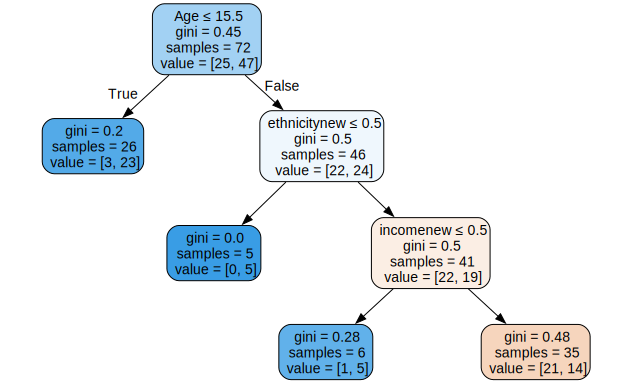

In [12]:
draw_tree(m, trn_xs, size=10)

In [13]:
mean_absolute_error(val_y, m.predict(val_xs))

0.6842105263157895

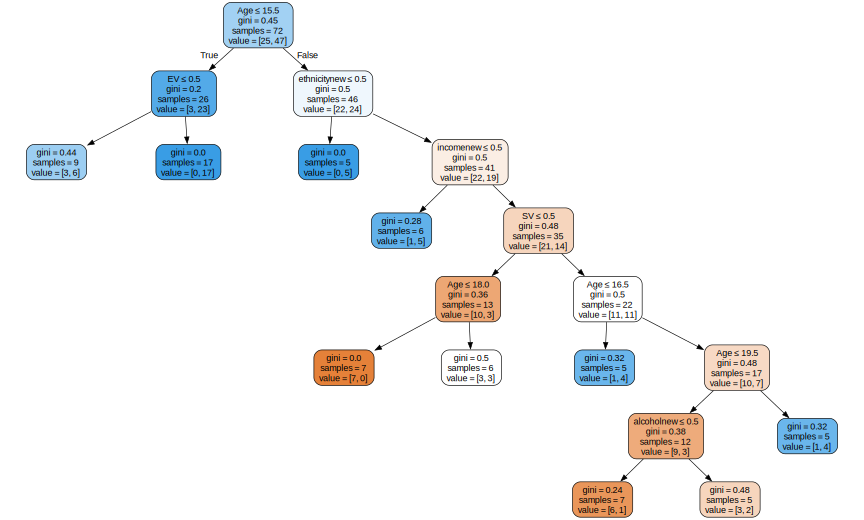

In [14]:
m = DecisionTreeClassifier(min_samples_leaf=5)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [15]:
mean_absolute_error(val_y, m.predict(val_xs))

0.42105263157894735

In [16]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [17]:
trees = [get_tree() for t in range(100)]

In [18]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.44684210526315793

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.3157894736842105

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

accuracy_score(val_y, rf.predict(val_xs))

0.6842105263157895

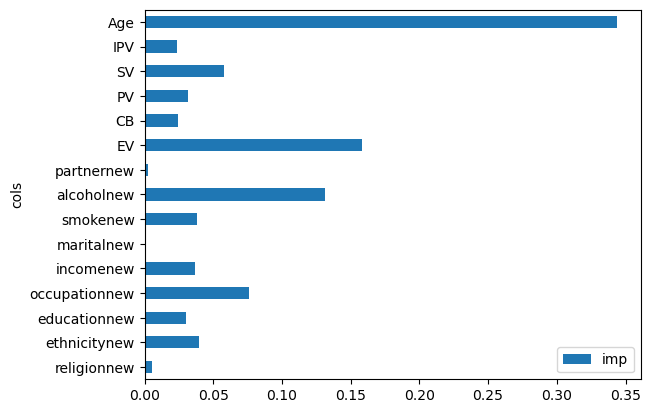

In [20]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

# Visualizing the Results

We can use the following code to visualize our first 3 trees.

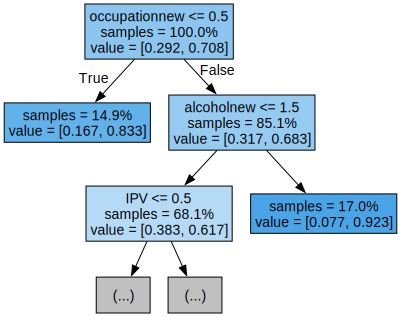

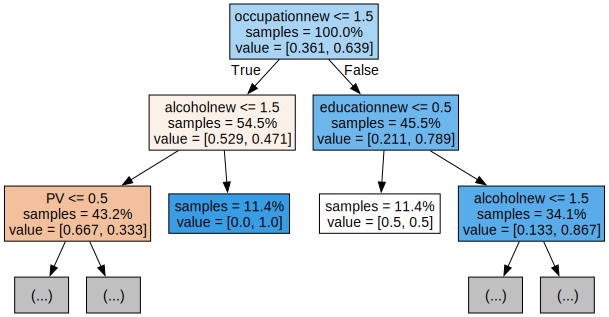

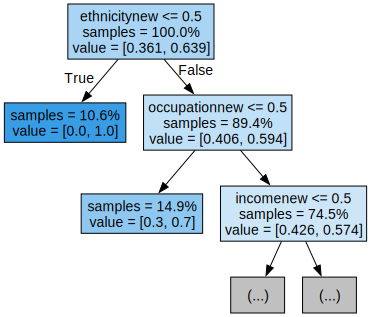

In [24]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trn_xs.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

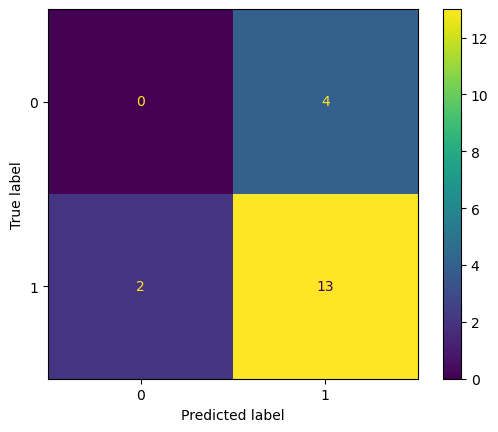

In [39]:
# Create the confusion matrix
cm = confusion_matrix(val_y, rf.predict(val_xs))

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Hyperparameter Tuning

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [30]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf2 = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf2, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(trn_xs, trn_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020E677CDC50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020E677CEE50>})

In [31]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 12, 'n_estimators': 228}


# Confusion Metrics

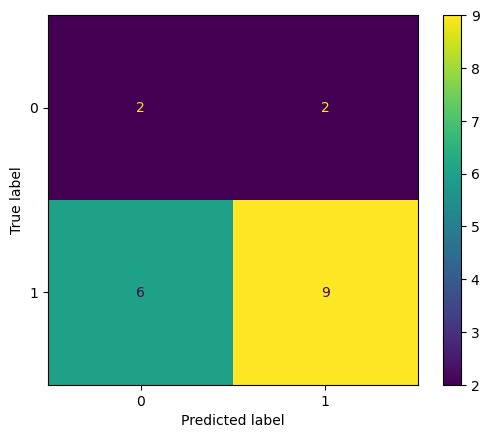

In [35]:
# accuracy_score(val_y, rf.predict(val_xs))

# Generate predictions with the best model
y_pred = best_rf.predict(val_xs)

# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [36]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5789473684210527
Precision: 0.8181818181818182
Recall: 0.6


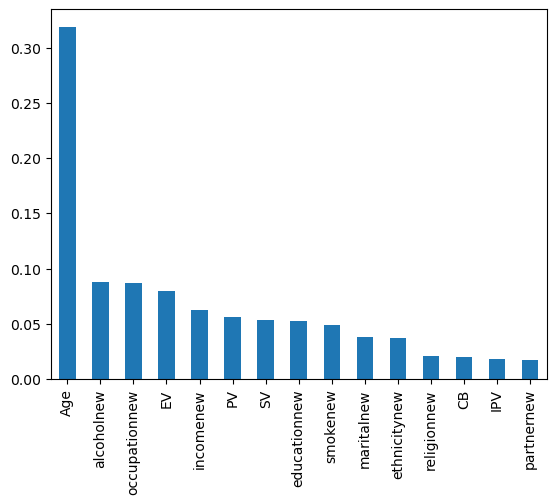

In [38]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=trn_xs.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

# Trying to see EV vs Depression

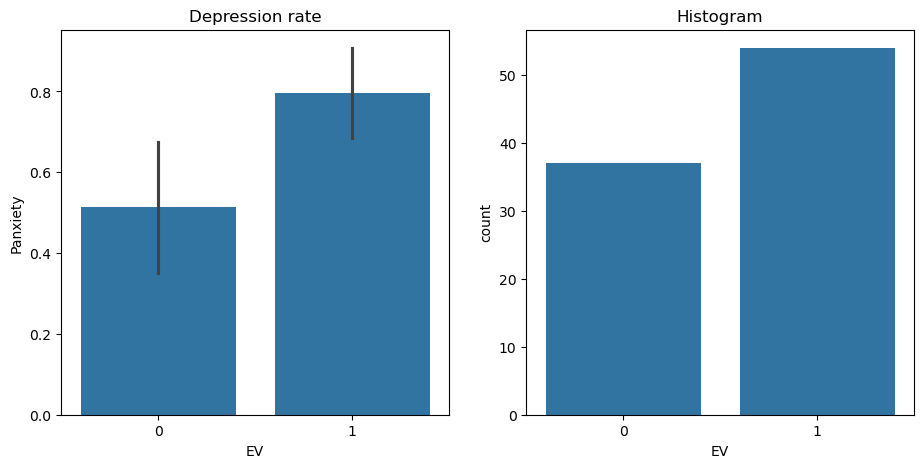

In [21]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="EV", ax=axs[0]).set(title="Depression rate")
sns.countplot(data=df, x="EV", ax=axs[1]).set(title="Histogram");

In [39]:
df

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,...,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
0,7,1,17,3,3,2,4,1,1,3,...,0,0,0,1,1,1,3,0,0,0
1,9,1,15,1,5,1,4,1,1,3,...,0,1,0,1,1,0,3,0,0,0
2,11,1,14,1,1,1,2,1,1,3,...,0,1,1,1,1,0,1,0,0,0
3,15,1,15,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0
4,43,1,17,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,94,2,37,1,1,2,2,1,2,3,...,1,1,1,1,0,1,1,0,0,1
87,54,1,29,1,1,2,2,1,3,3,...,1,1,1,1,0,1,1,0,1,1
88,91,2,17,1,5,2,4,1,1,3,...,0,1,0,1,1,1,3,0,0,1
89,95,2,39,1,1,2,1,1,2,3,...,1,1,1,1,0,1,2,0,0,1
